# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
import librosa
import numpy as np
import scipy 
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [2]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

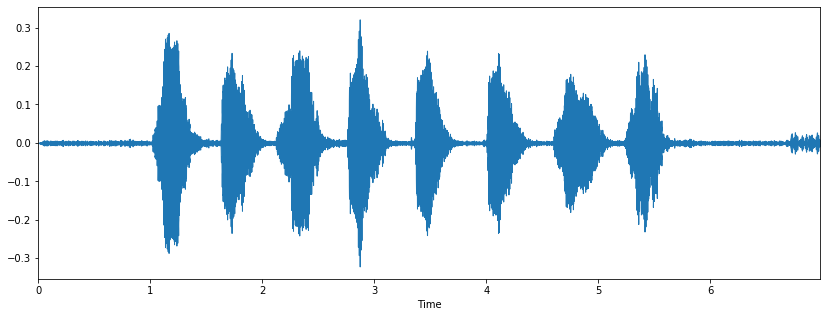

In [3]:
wav, sr = librosa.load("resources/waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

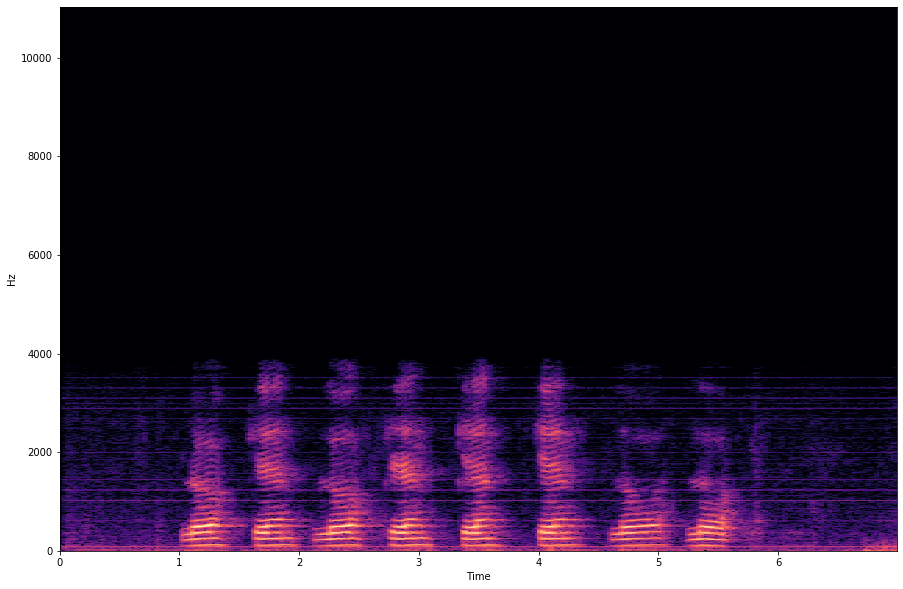

In [4]:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz');

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

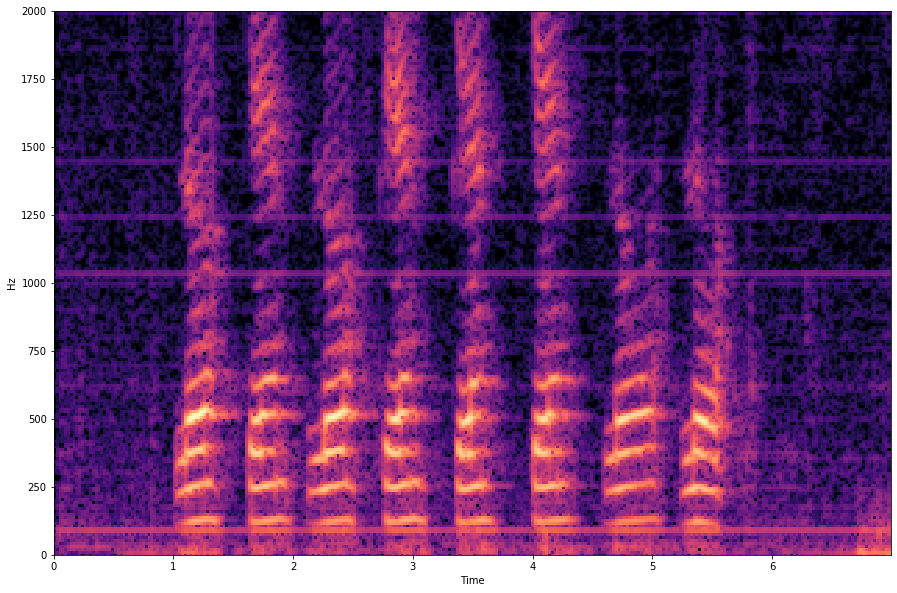

In [5]:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz');
plt.ylim(0, 2000);

1. - Слова можно например разделить по энергии на частотах с 1000-1250. При слове КЕН (yes) присутствует малая энергия по сравнению с ЛЁ (no).
2. - В основном энергия сконцентрированал с областях от 50 - 750 Гц.

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [6]:
def mel(f):
    return 2595. * np.log10(1. + f / 700.)

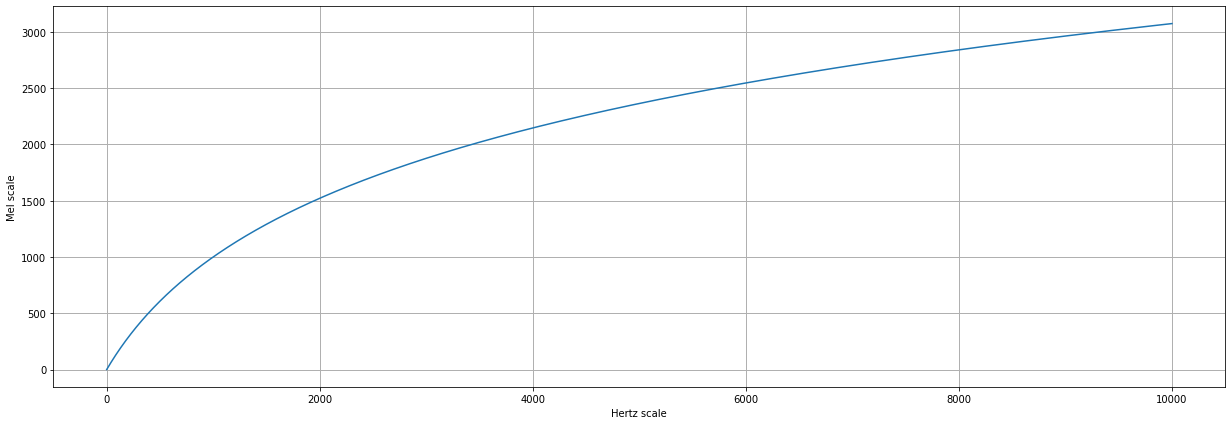

In [7]:
x = np.linspace(0, 10000, 10000)
y = mel(x)

plt.figure(figsize=(21, 7))
plt.plot(x, y)
plt.xlabel('Hertz scale')
plt.ylabel('Mel scale')
plt.grid(linestyle='-', linewidth=1)
plt.show()

In [8]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("Ok!")
test_mel() 

Ok!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [9]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.)

def mel2hz(mel):
    return 700 * (10 ** (mel /  2595.0) - 1)

In [10]:
def mel_filters(sr, n_fft, n_mels=40):    
    
    f_max = int(sr / 2)
    hz = np.linspace(0, f_max, n_fft // 2 + 1, endpoint=True)
    mels = np.linspace(0, hz2mel(f_max), n_mels + 2)
    mel_f = mel2hz(mels)
    
    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, hz)

    fbank = np.zeros((n_mels, n_fft // 2 + 1))
    for i in range(n_mels):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]
        fbank[i] = np.maximum(0, np.minimum(lower, upper))

    enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
    fbank *= enorm[:, np.newaxis]

    return fbank

In [11]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All ok!")

All ok!


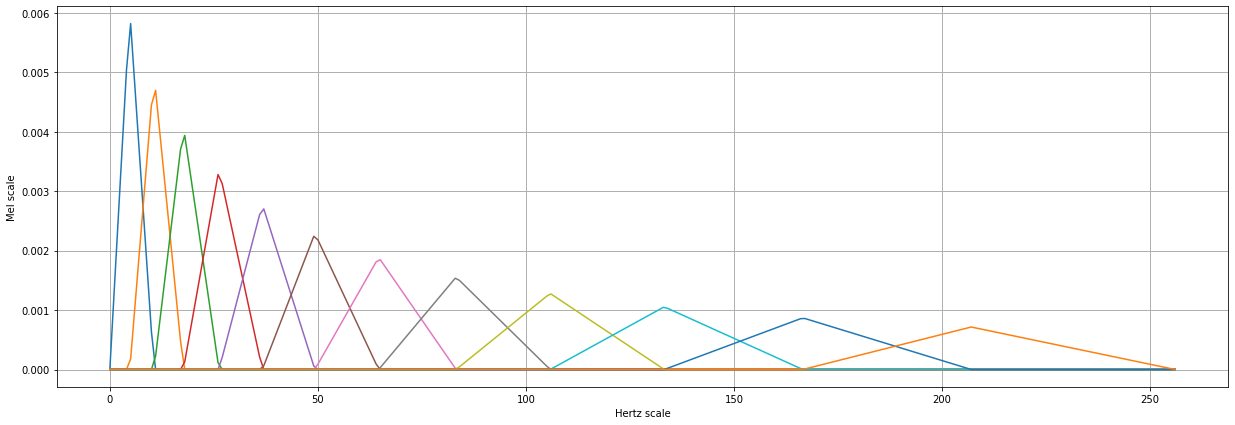

In [12]:
plt.figure(figsize=(21, 7))

filters = mel_filters(16000, 512, 12)

for y in filters:
    plt.plot(y)
plt.xlabel('Hertz scale')
plt.ylabel('Mel scale')
plt.grid(linestyle='-', linewidth=1)
plt.show()

In [13]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]

    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000
    win_length = window_ms * sr // 1000
    spec = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length)) ** 2
    mel_basis = mel_filters(sr, n_fft, n_fbanks)
    return np.dot(mel_basis, spec)

In [14]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
    assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
    assert test_fbank(wav, sr) == 0 , "All wav test failed"
    print("All ok!")
test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40)

TEST PASSED


0

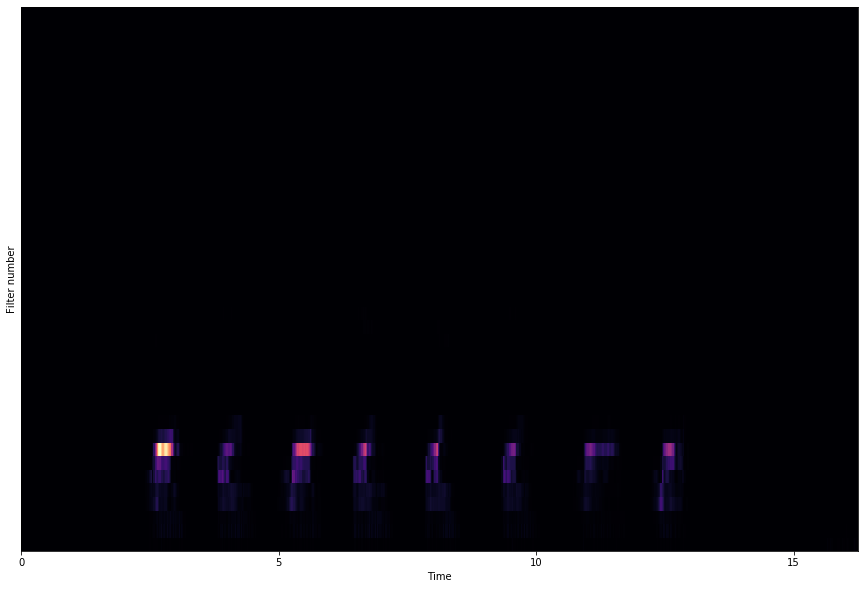

In [15]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 3 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [16]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    mel_spectrogram = get_fbanks(wav = wav, sr = sr, window_ms=window_ms, step_mc=step_mc)
    logmel = 10 * np.log10(mel_spectrogram)
    logmel = np.maximum(logmel, logmel.max() - 80)
    mfcc = scipy.fftpack.dct(logmel, axis=0, type=2, norm='ortho')[:n_mfcc]
    return mfcc

In [17]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, n_mels=40, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc, atol=1e-04):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


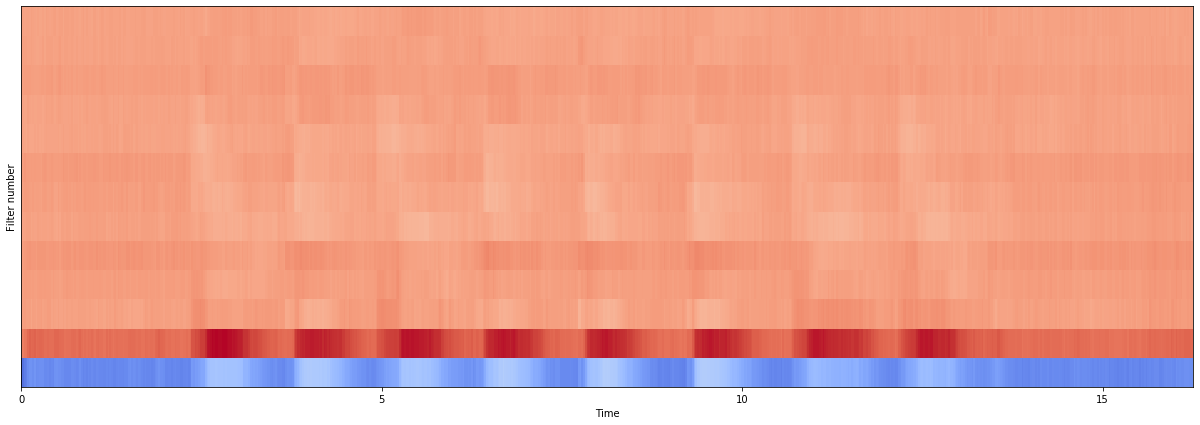

In [18]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(21, 7))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [19]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels, sr

In [20]:
X, Y, sr = load_yn_dataset("resources/waves_yesno/")

Отделим 20% для теста

In [21]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *4 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.
Реализуйте простой VAD.
Настройте VAD, чтобы хорошо определялись границы слов.

In [22]:
import math
import torch
from scipy.signal import butter, lfilter, freqz

In [23]:
class VAD():
    
    def __init__(self, signal, sr, window_ms=0.05, high_freq=600, speechlen=4000):
        self.signal = signal
        self.sr = sr
        self.fmax = sr / 2
        self.window_ms = window_ms
        self.high_freq = high_freq
        self.speechlen = speechlen
        
    def butter_lowpass(self, cutoff, order=5):
        nyq = 0.5 * self.sr
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(self, cutoff, order=5):
        b, a = self.butter_lowpass(cutoff, order=order)
        y = lfilter(b, a, self.signal)
        self.signal = y
        self.fmax = cutoff

    def window(self):
        winsize = int(self.window_ms * self.sr)
        fltr = np.ones(winsize)
        result = np.convolve(abs(self.signal), fltr) / np.sum(fltr)
        result /= result.max()
        self.energy = result ** 2

    def smooth(self, result, speechlen):
        diff = np.diff(result)
        index = np.where(diff != 0)[0]
        l = []
        for i in range(0, len(index), 2):
            voice_len = index[i + 1] - index[i]
            if voice_len < speechlen:
                result[index[i] - 200:index[i+1]+200] = 0
        return result

    def find_voice(self, threshold=1000):
        
        self.butter_lowpass_filter(self.high_freq)
        self.window()
        winsize = int(self.window_ms * self.sr)    
        result = (self.energy >= threshold).astype(int)
        fltr = np.ones(winsize)
        result = np.convolve(self.energy, fltr) / np.sum(fltr)
        result /= result.max()        
        result = np.where(result < np.median(result) * 2, 0, 1)
        result = self.smooth(result, self.speechlen)
        self.voice = result
        return result

    def plot_enegry(self):
        plt.figure(figsize = (21, 6))
        plt.plot(self.energy)
        plt.show()

    def plot_wave(self):
        plt.figure(figsize=(21, 6))
        plt.plot(self.signal)
        plt.show()
        
    def plot_voice(self, text):
        plt.figure(figsize=(21, 6))
        plt.plot(self.voice, 'r', label='Voice_detected')
        plt.plot(self.signal, 'b', label='Origin signal', alpha=0.5)
        plt.legend(loc="best")
        plt.title(text)
        plt.show()  
        
    def plot_stft(self):
        plt.figure(figsize=(21, 6))
        f, t, Zxx = scipy.signal.stft(self.signal, self.sr, nperseg=1000)
        plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(0, self.fmax)
        plt.show()

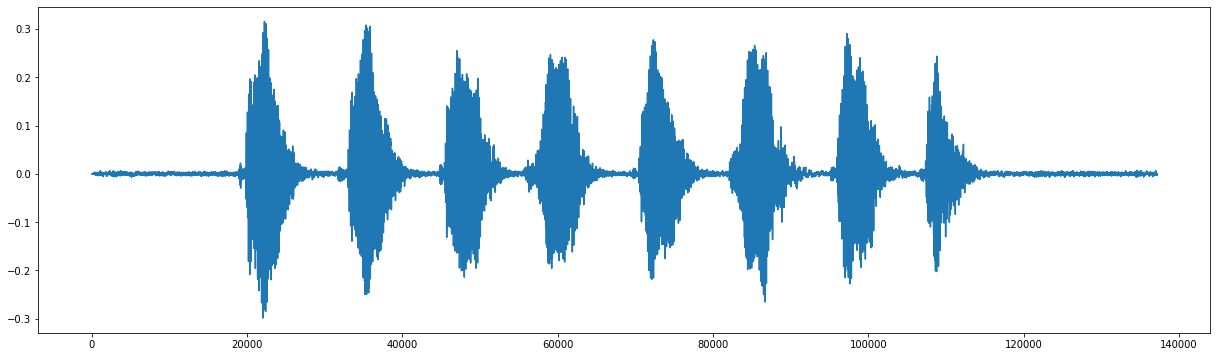

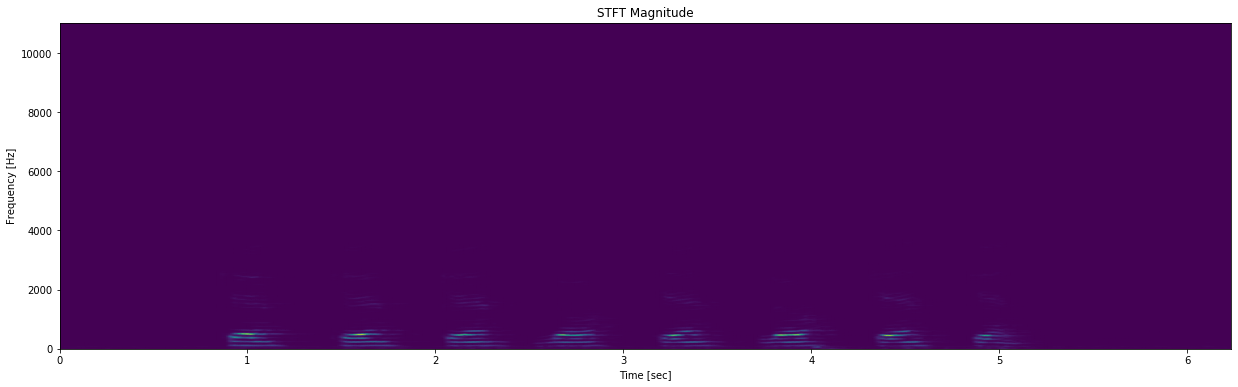

In [24]:
test = VAD(X_train[0], sr)
test.plot_wave()
test.plot_stft()

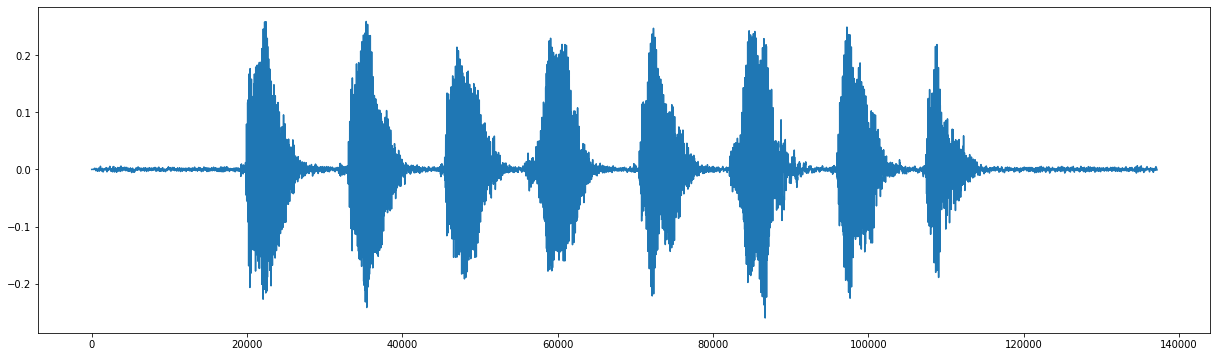

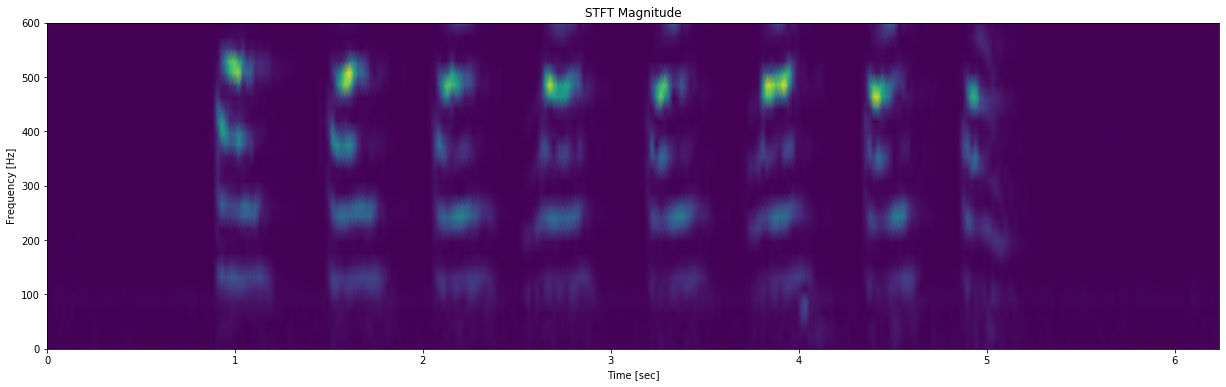

In [25]:
test.butter_lowpass_filter(600)
test.plot_wave()
test.plot_stft()

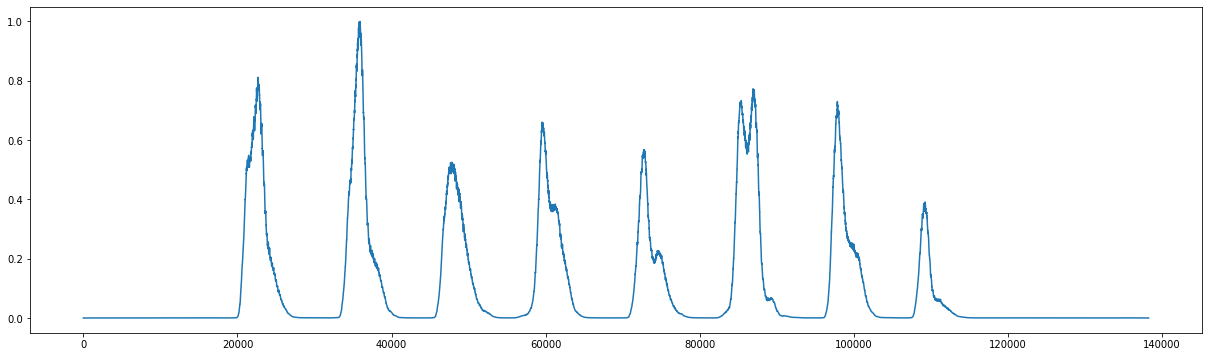

In [26]:
test.window()
test.plot_enegry()

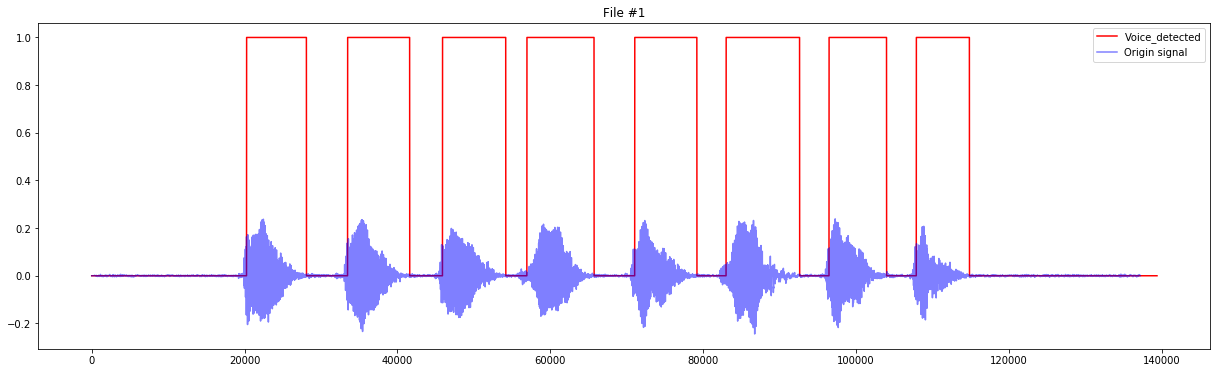

In [27]:
test.find_voice(800)
test.plot_voice(f'File #{1}')

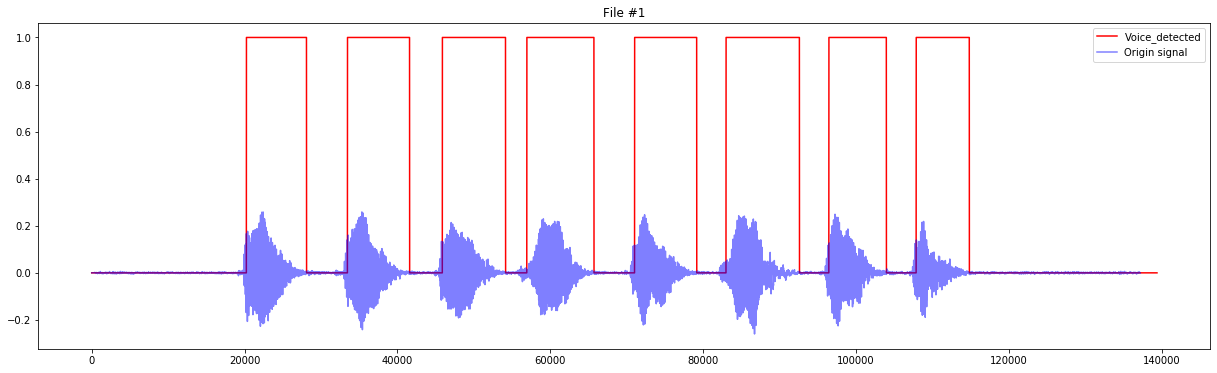

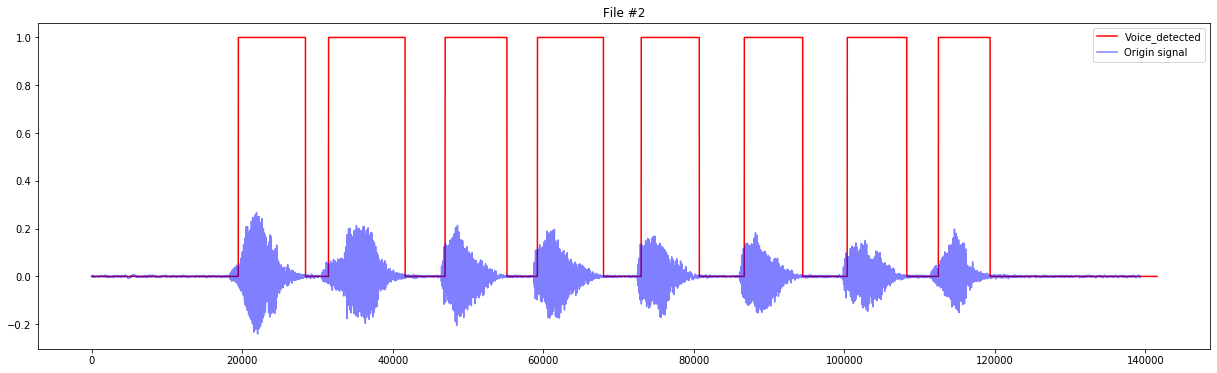

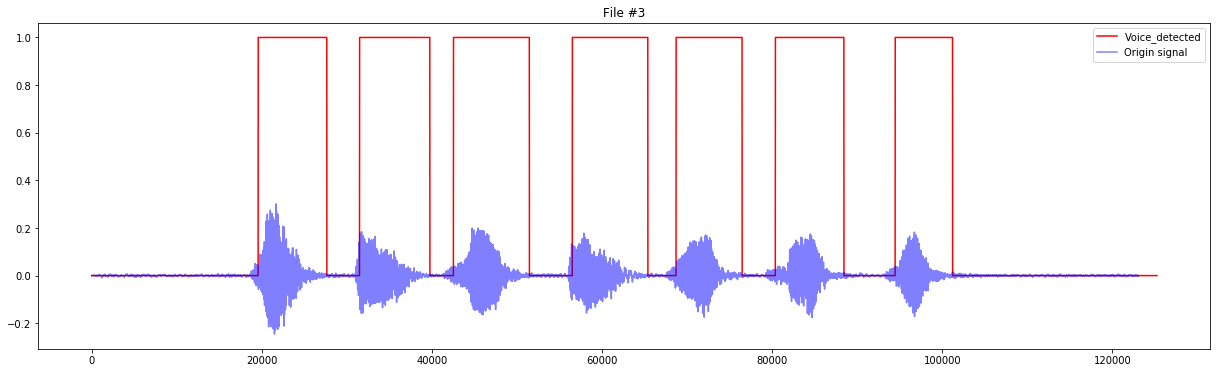

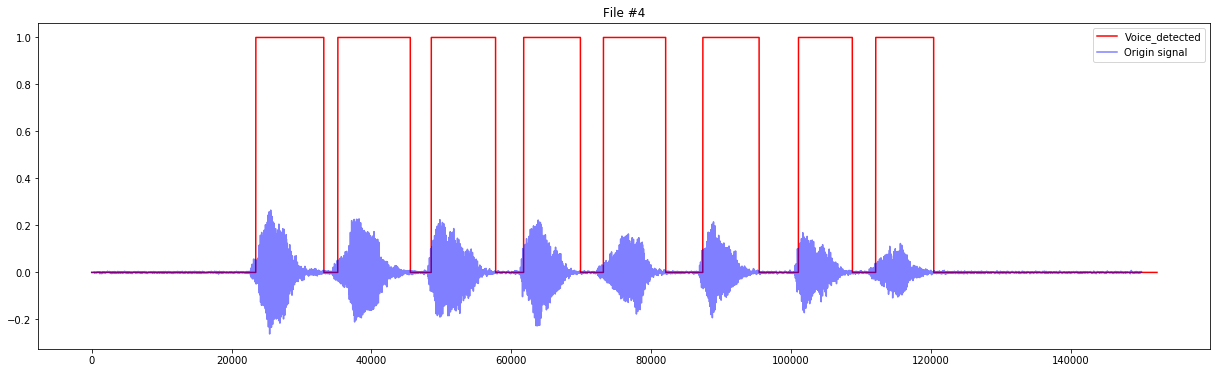

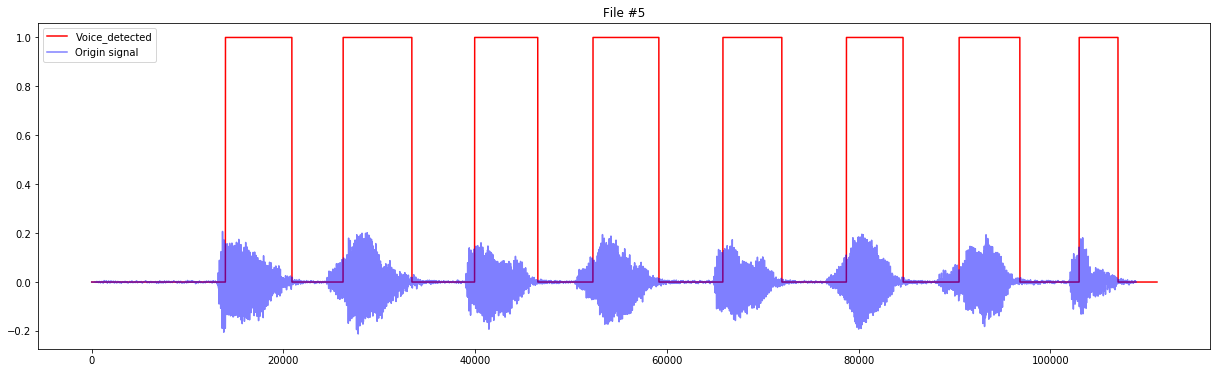

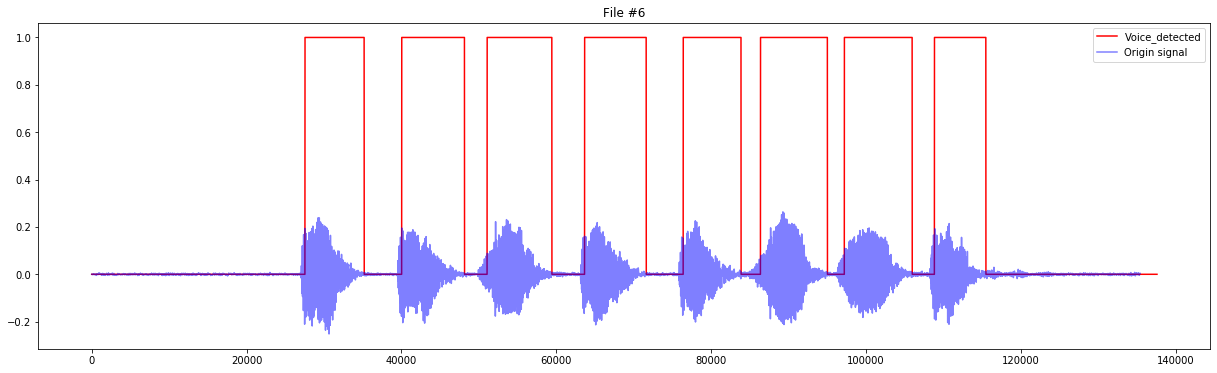

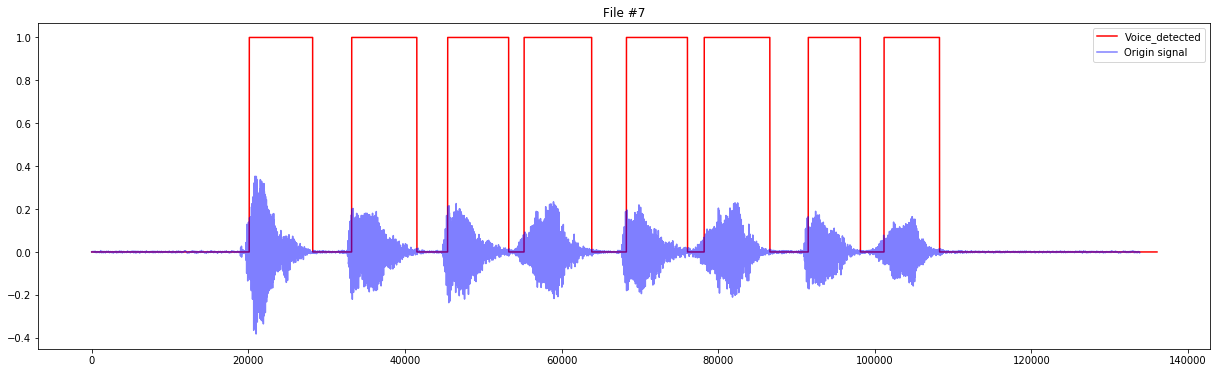

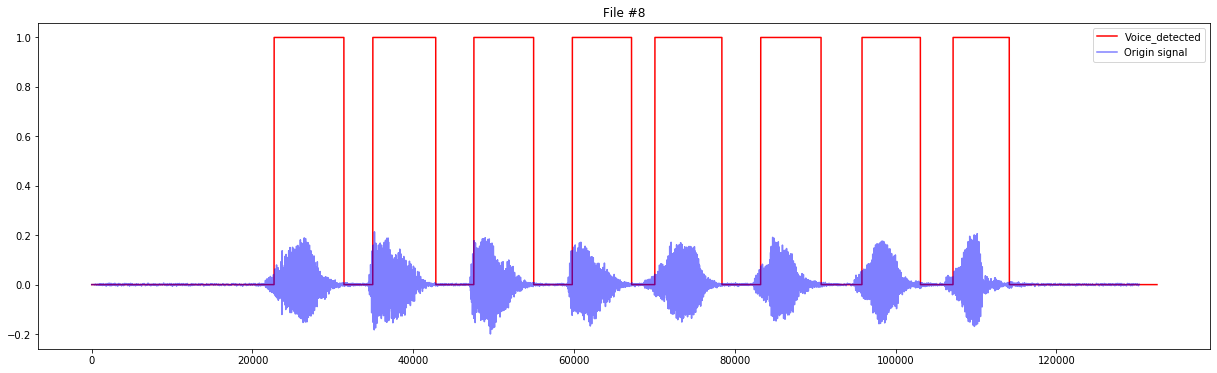

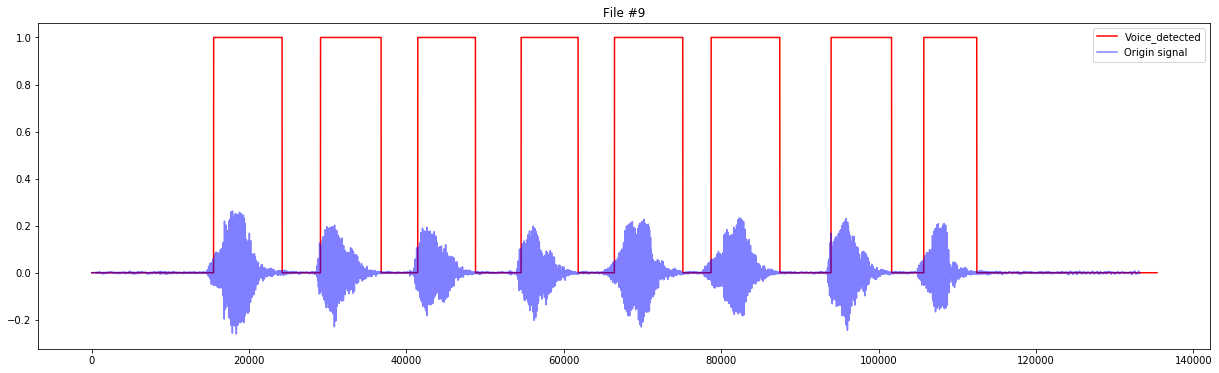

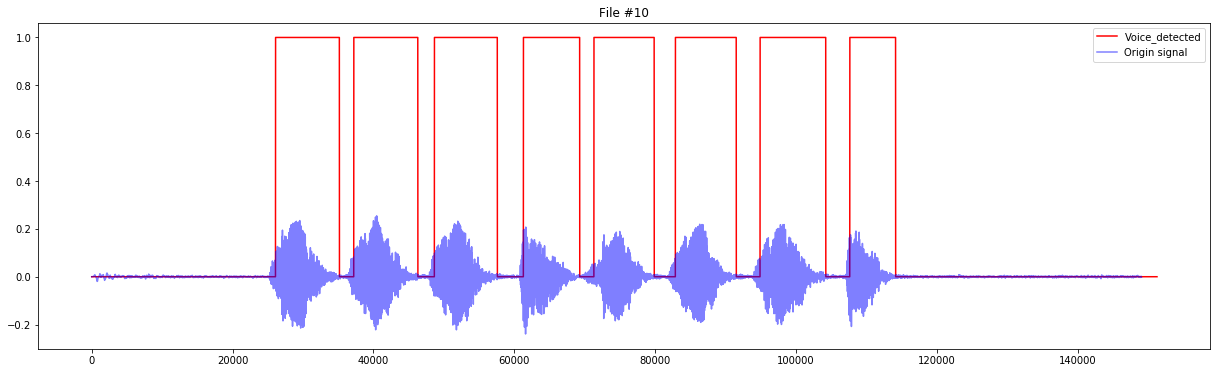

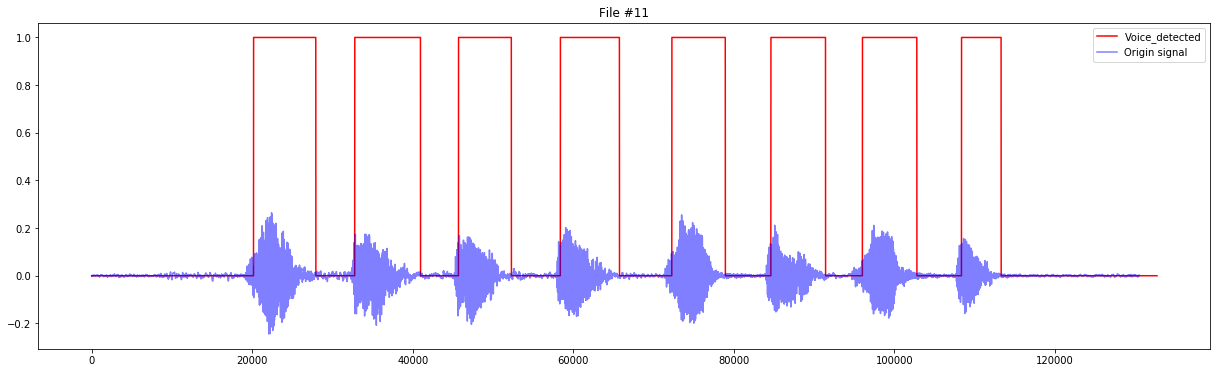

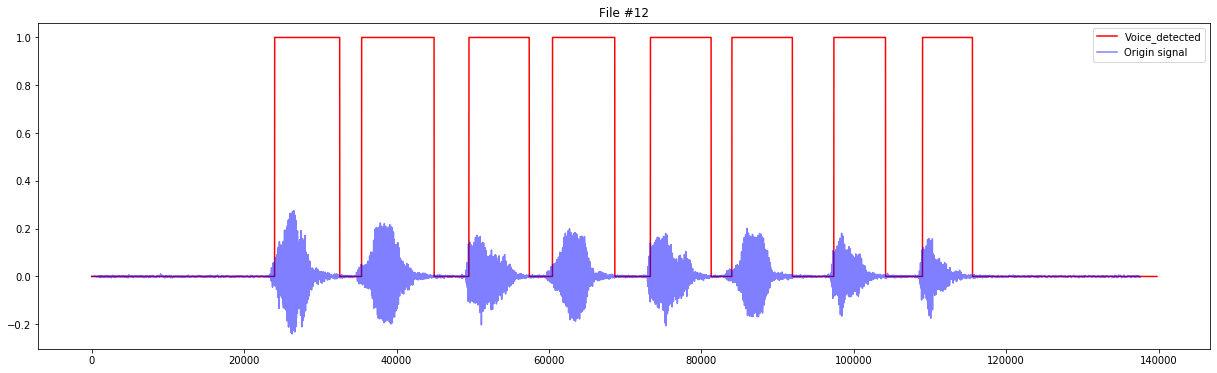

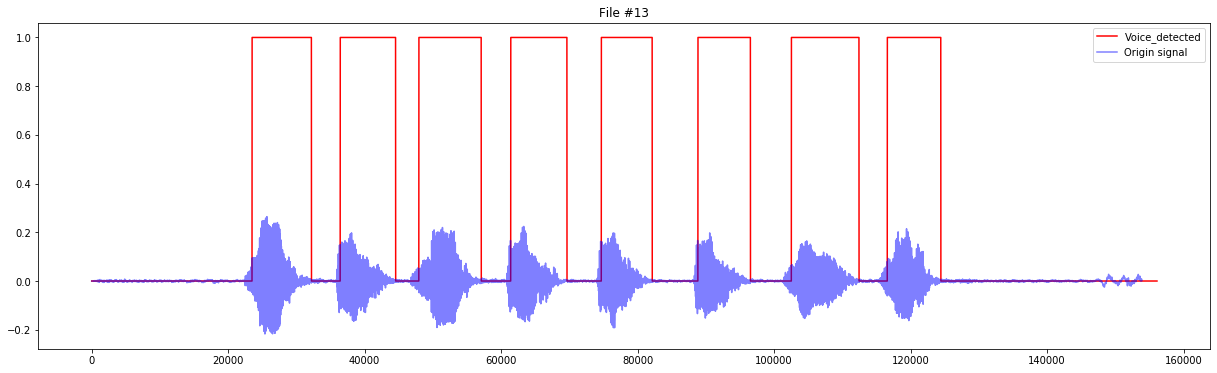

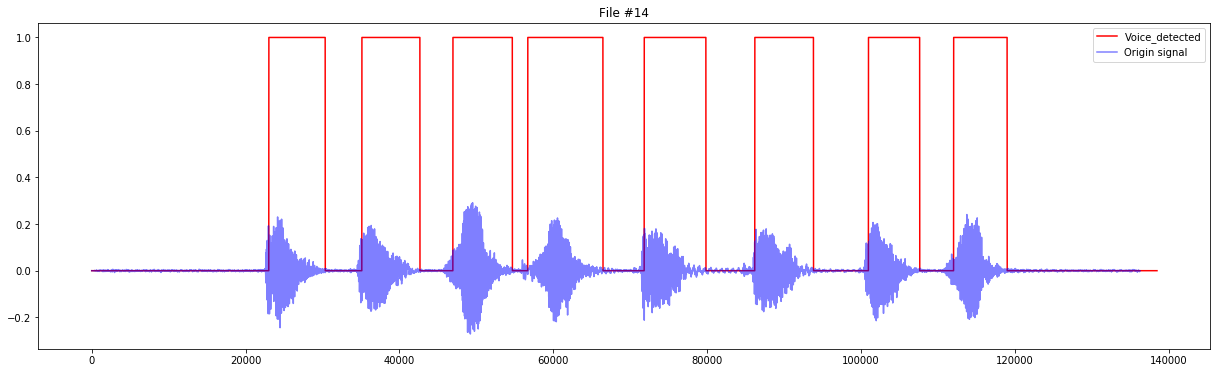

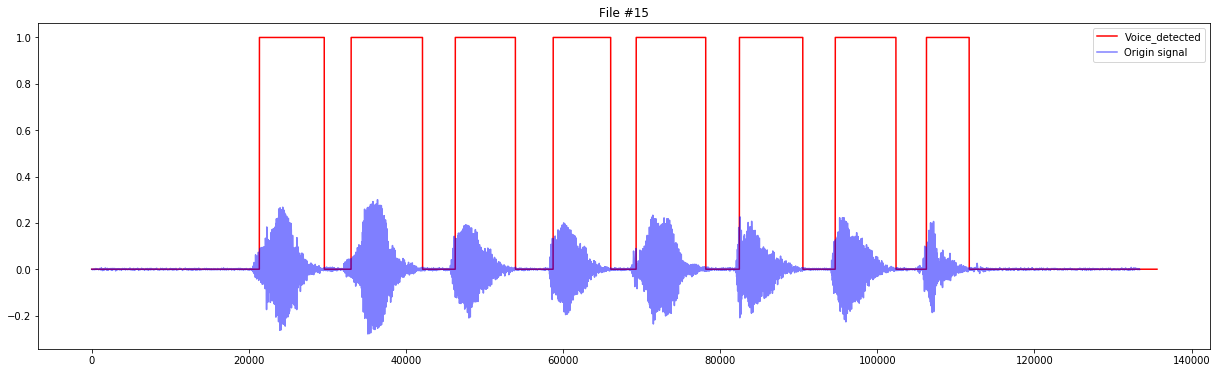

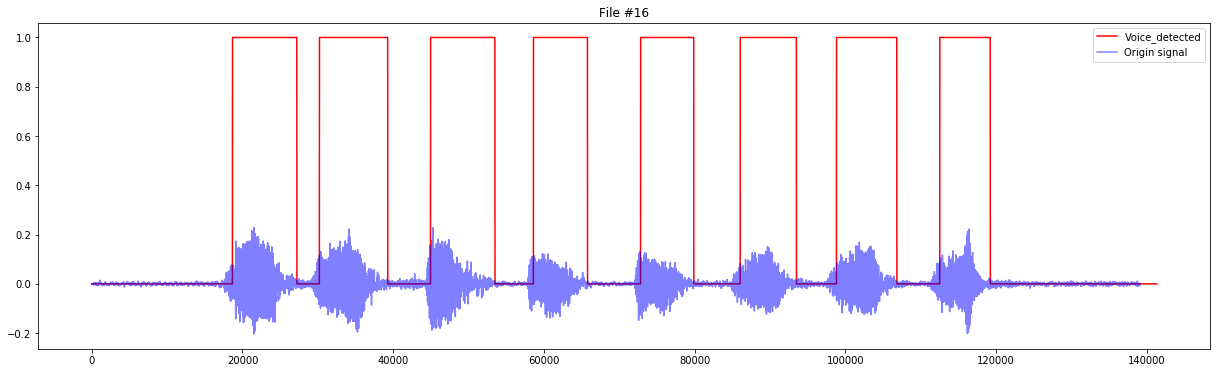

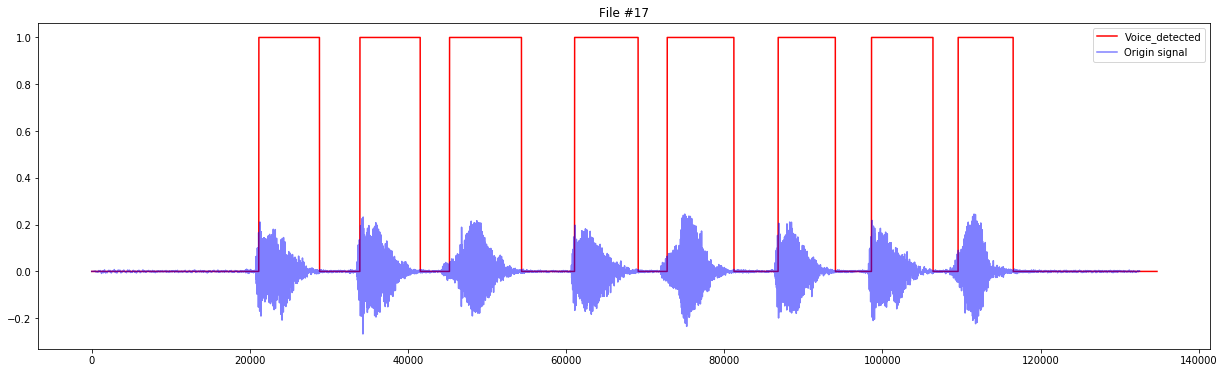

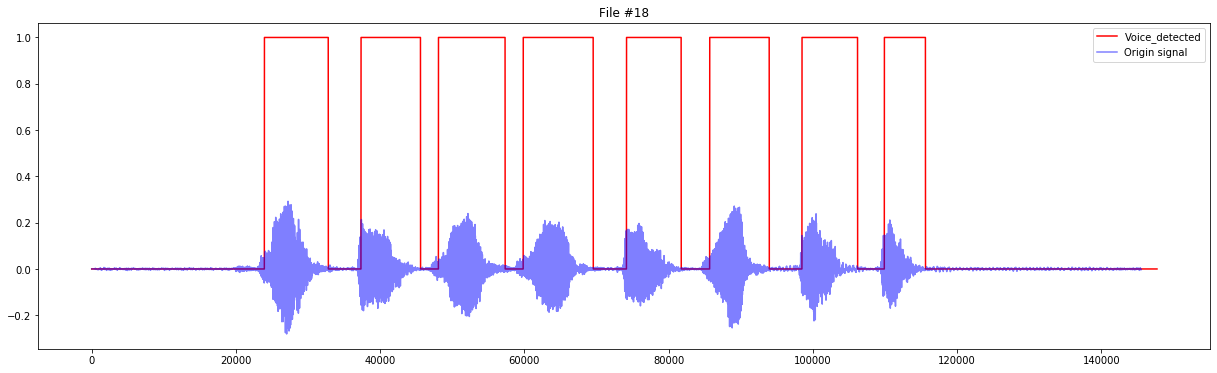

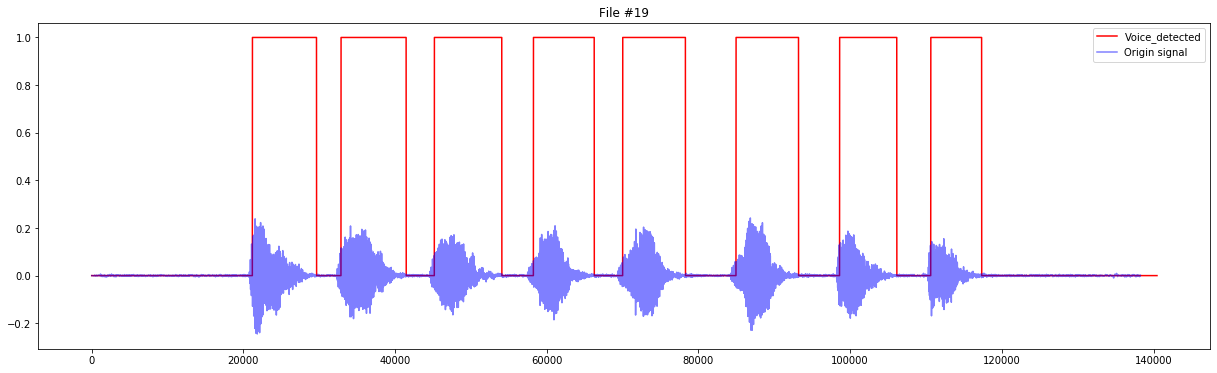

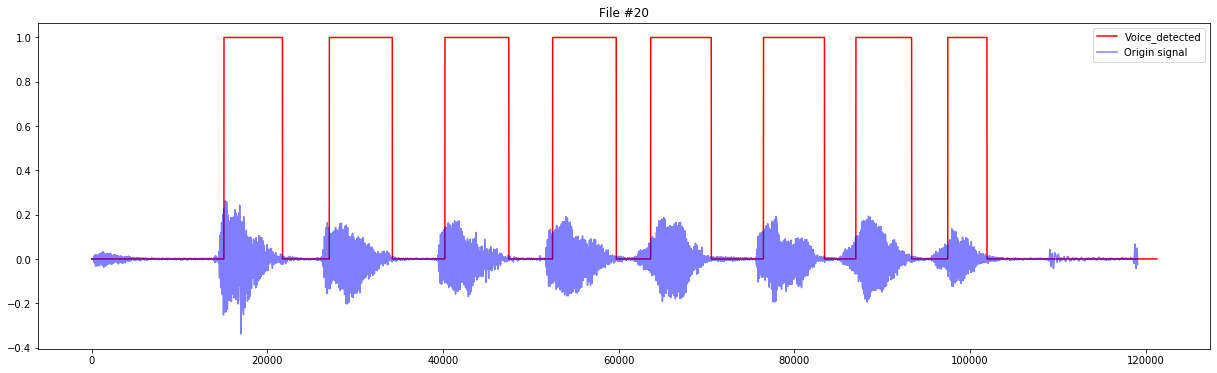

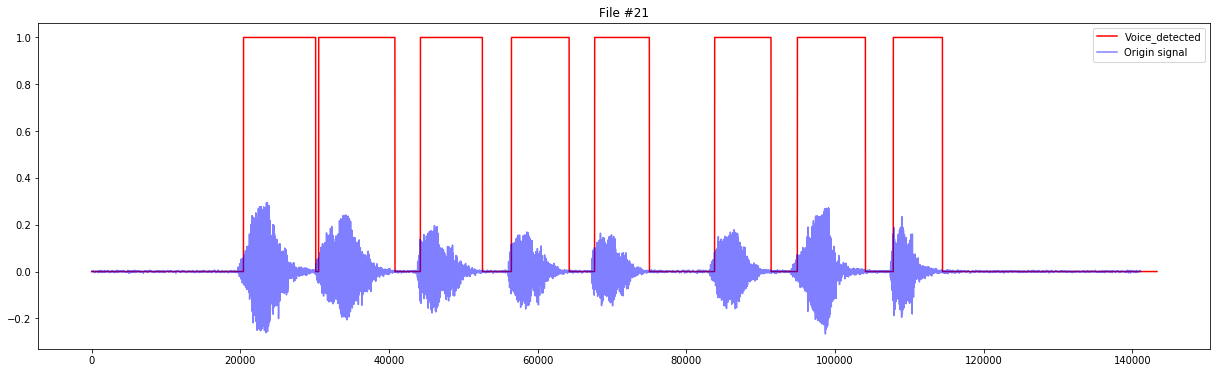

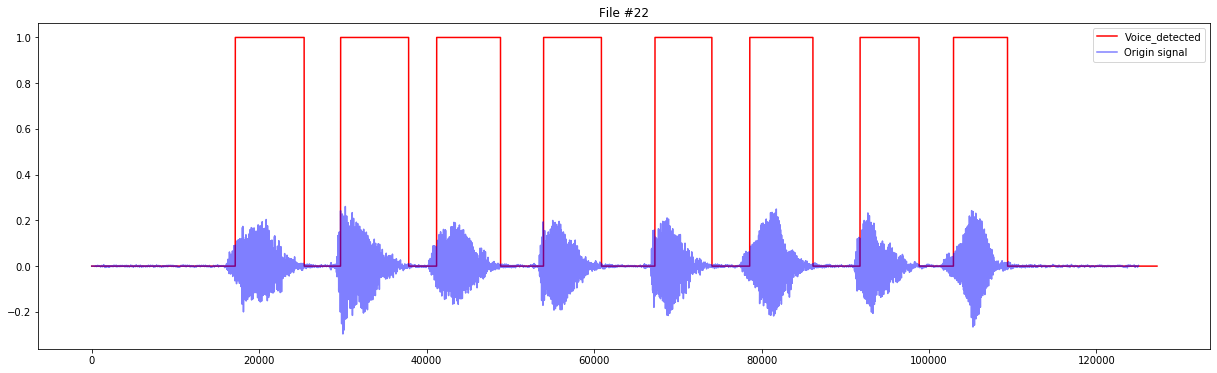

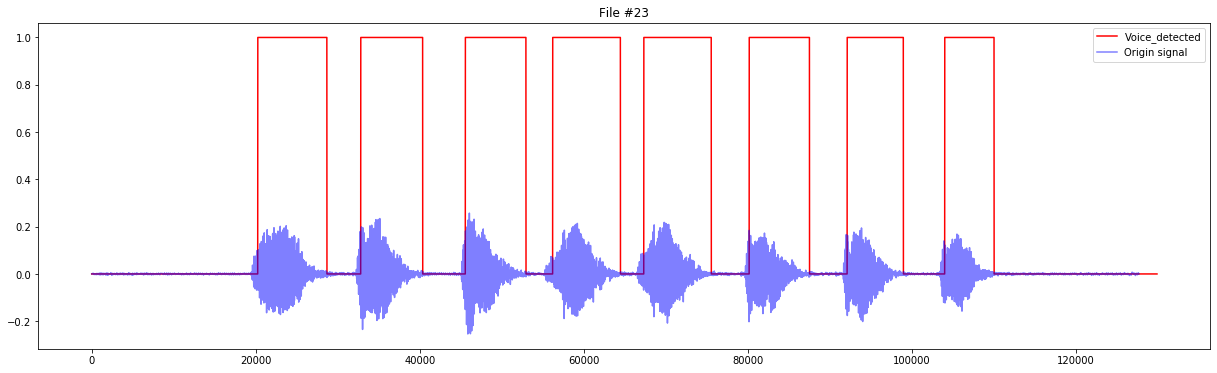

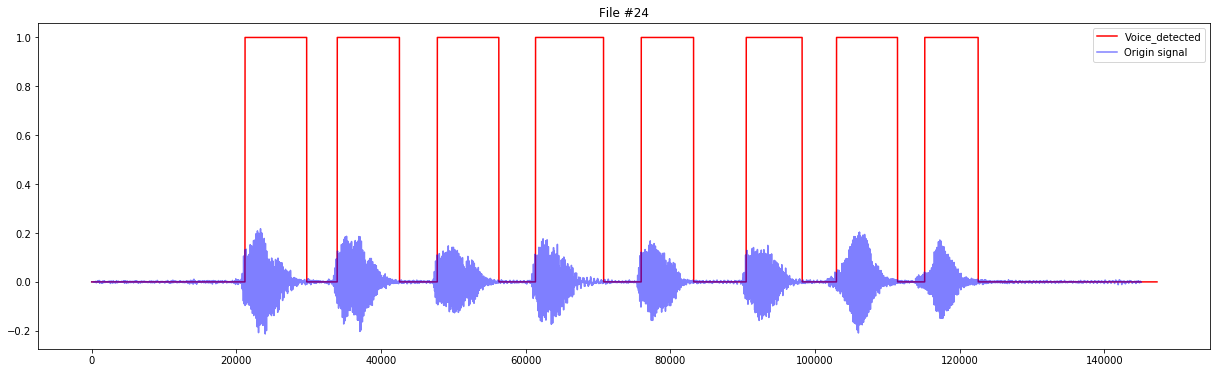

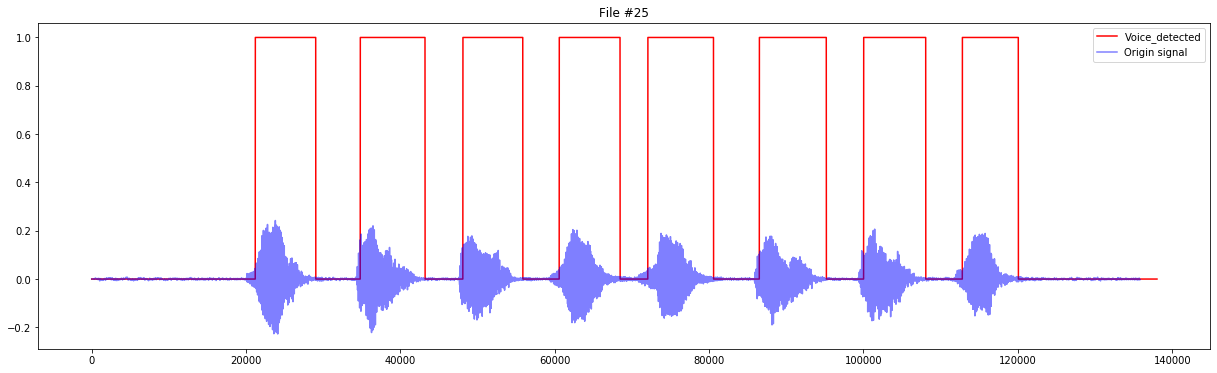

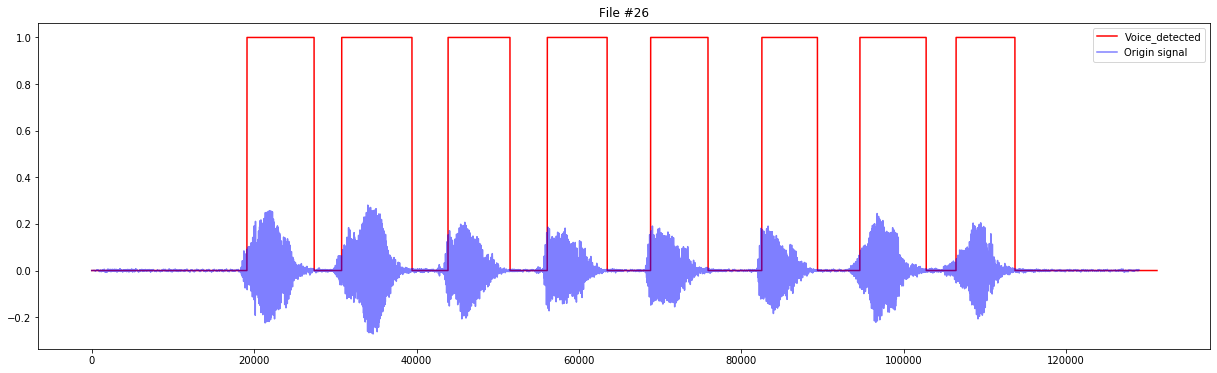

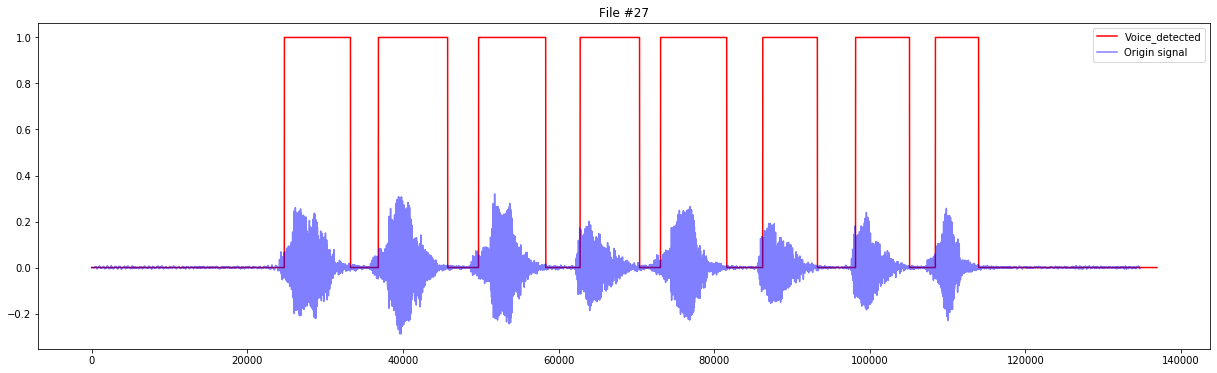

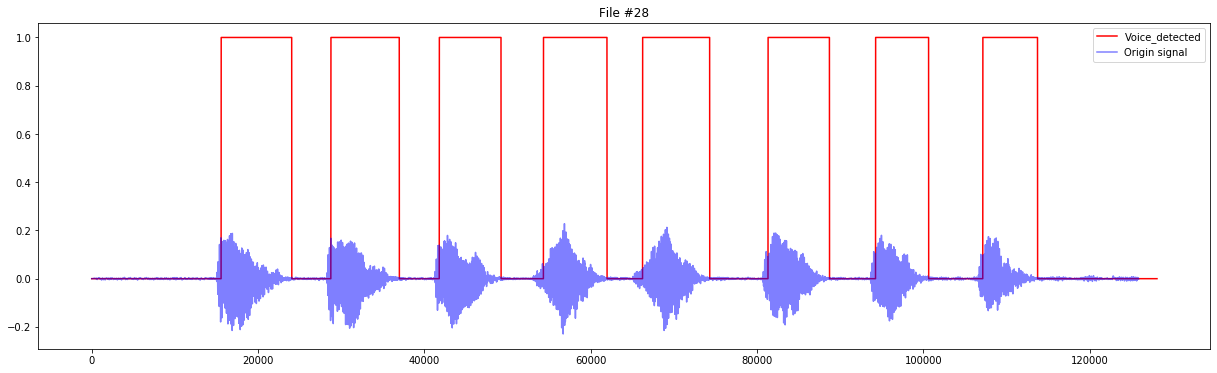

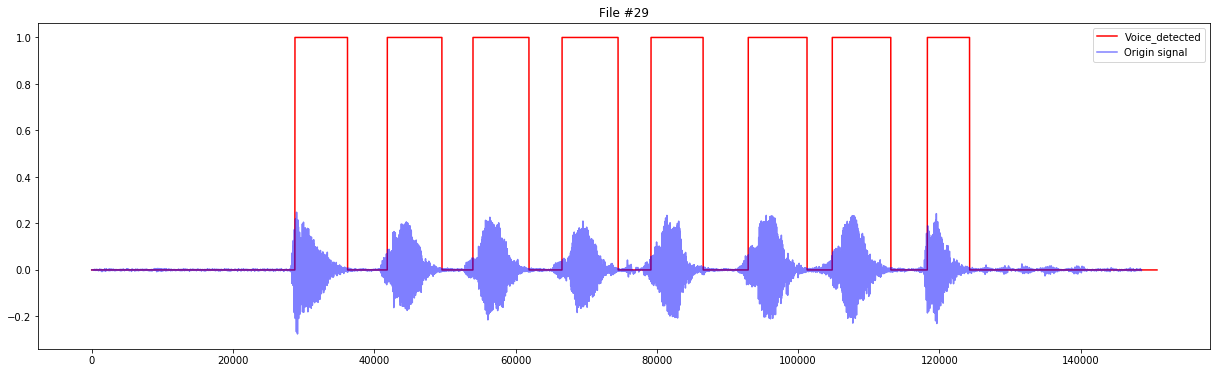

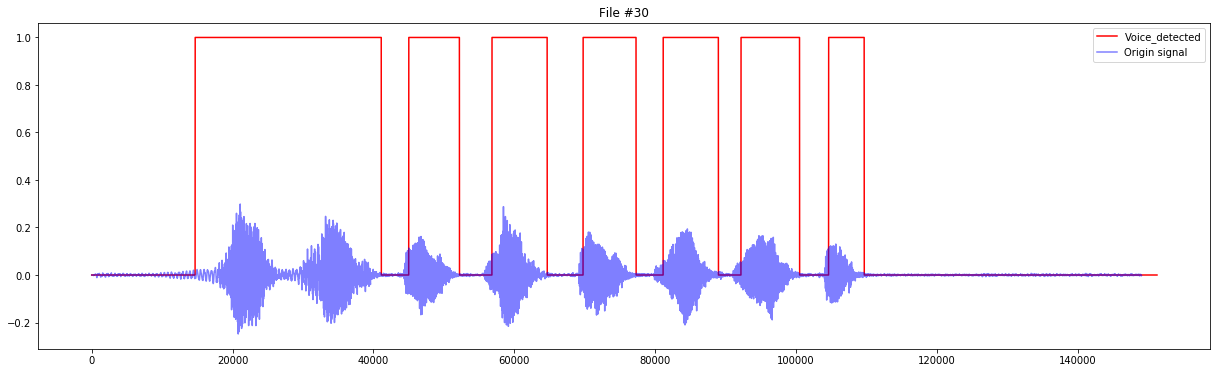

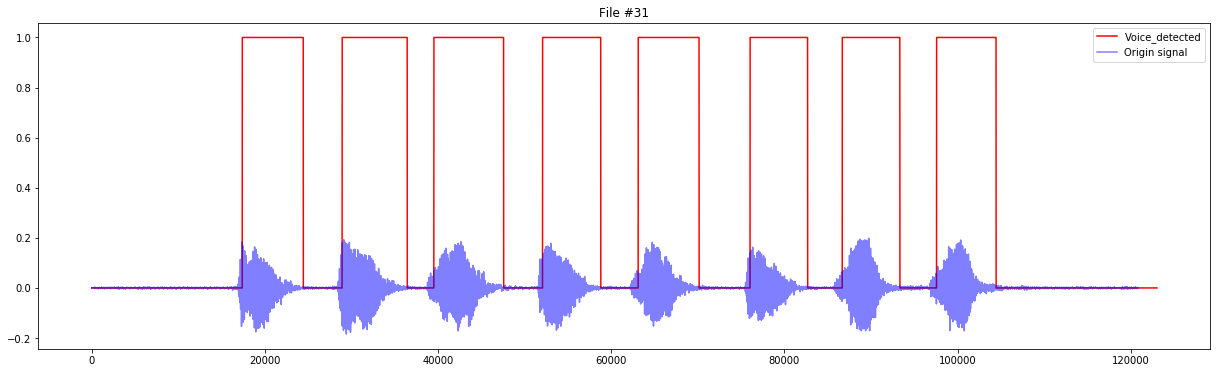

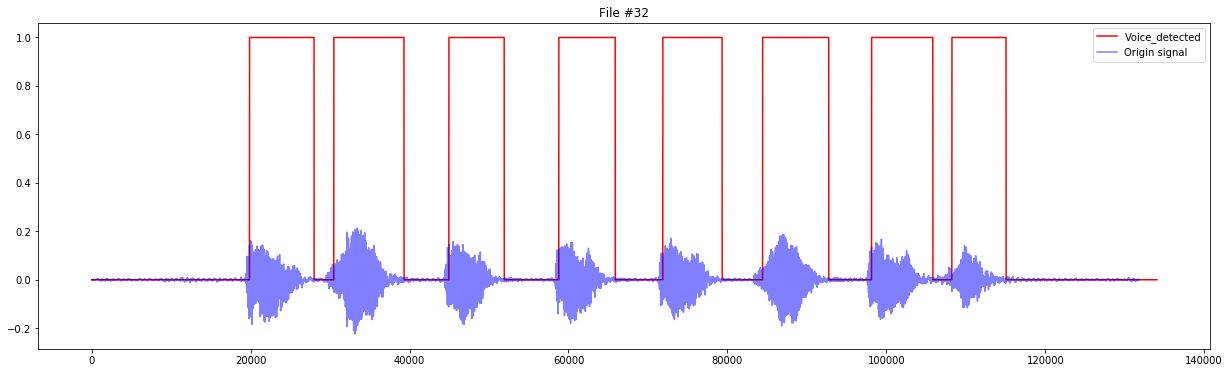

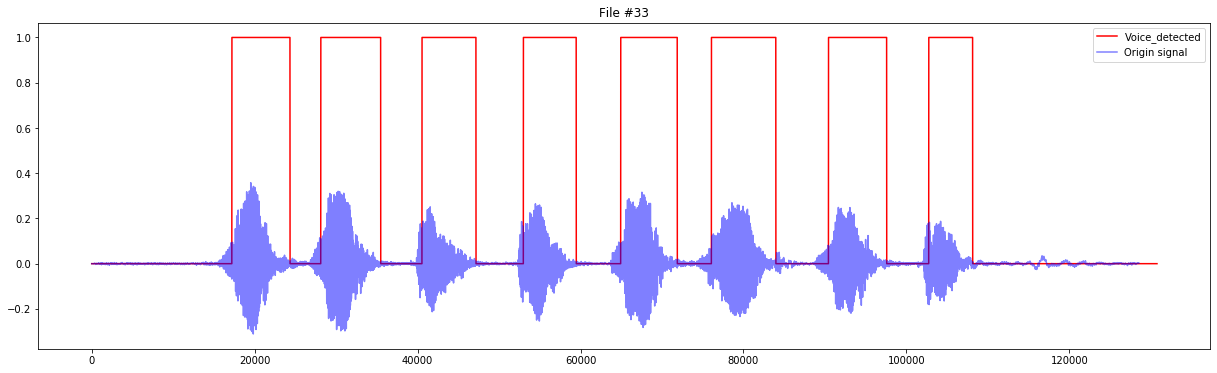

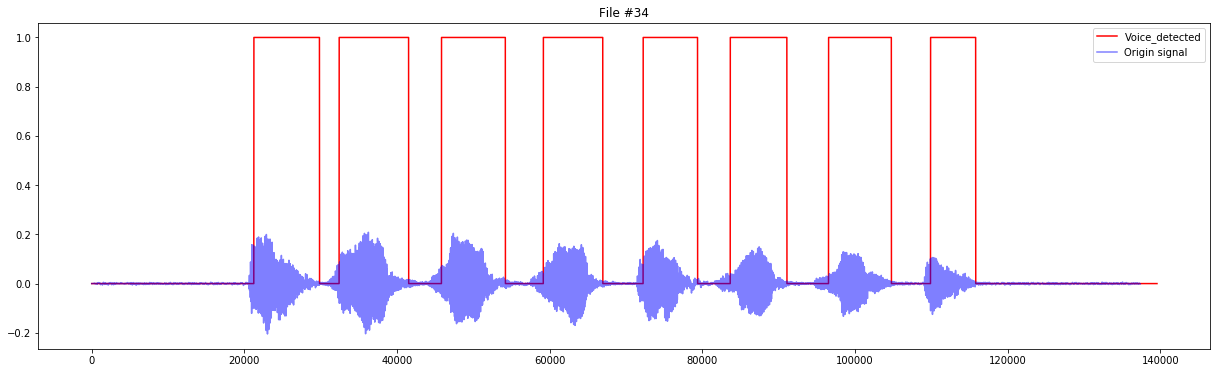

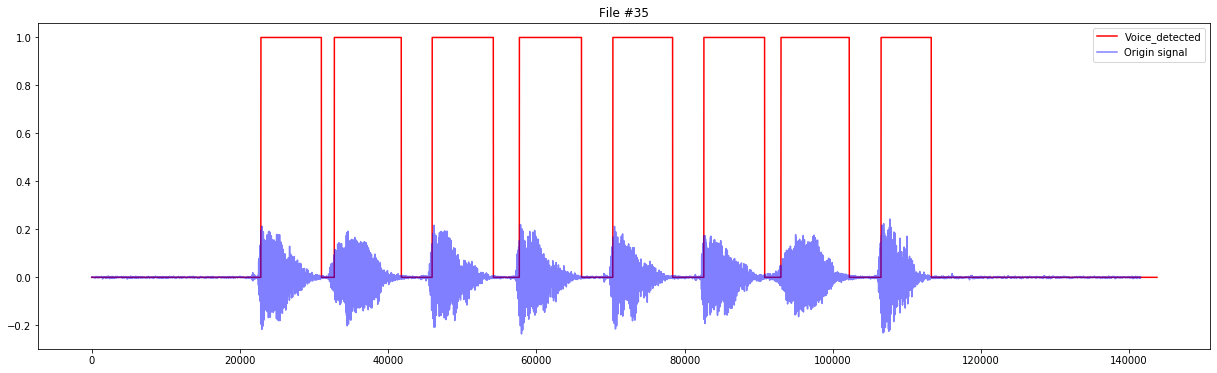

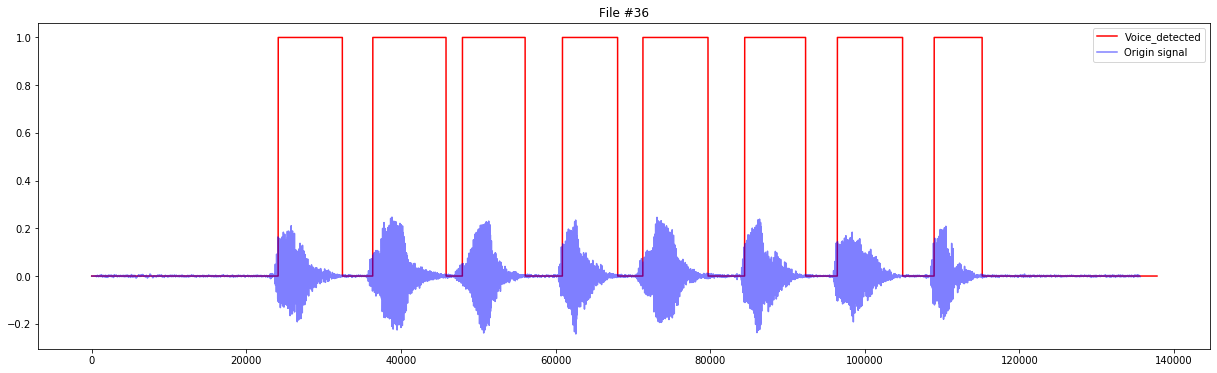

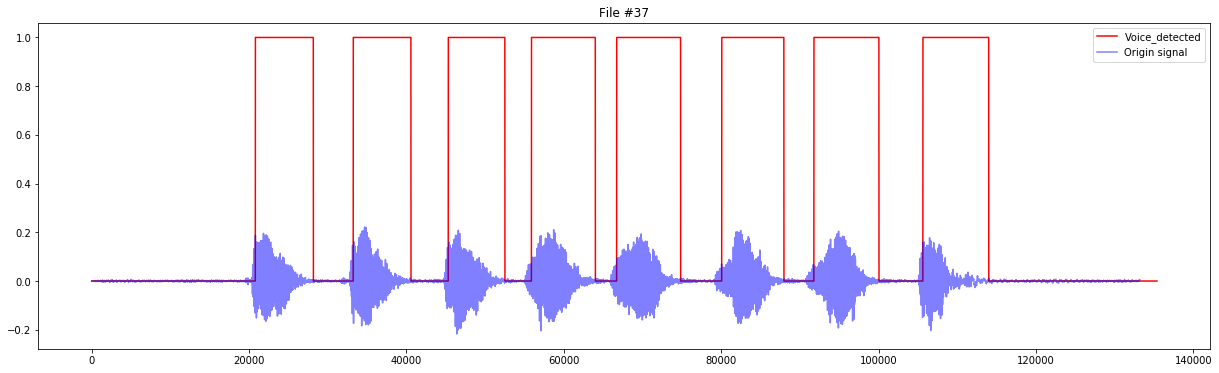

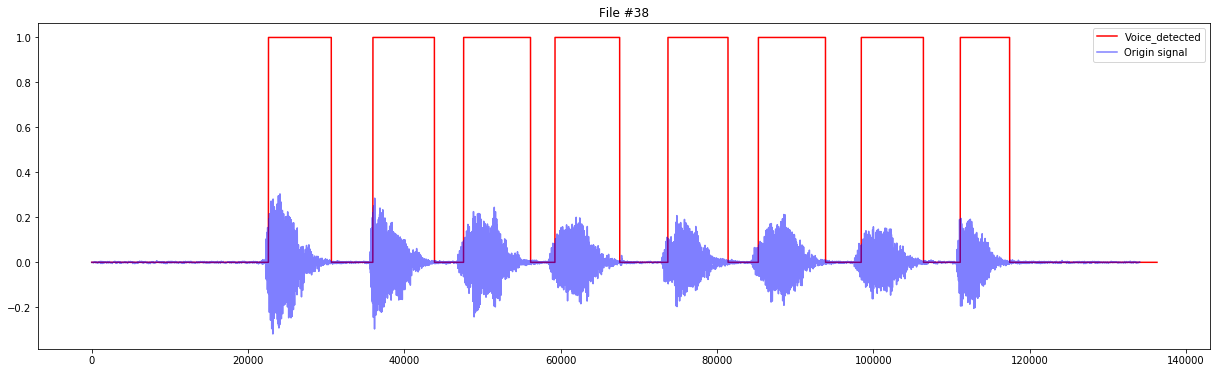

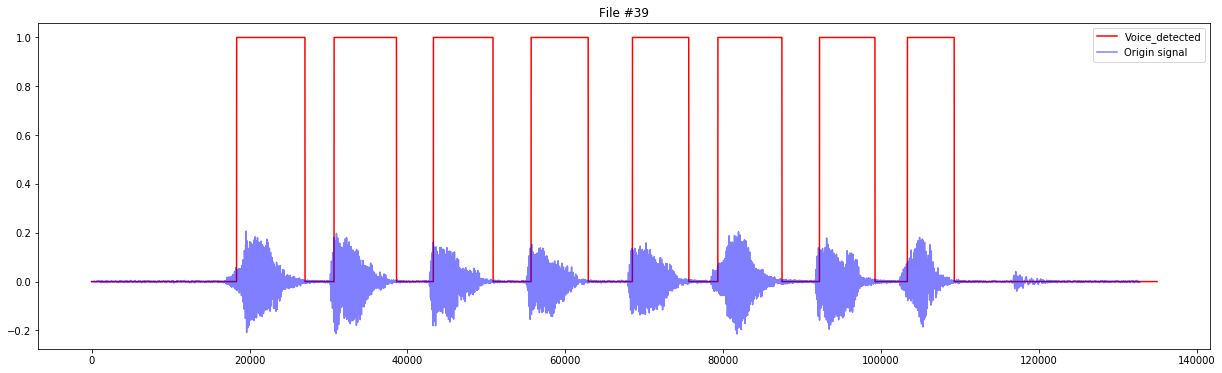

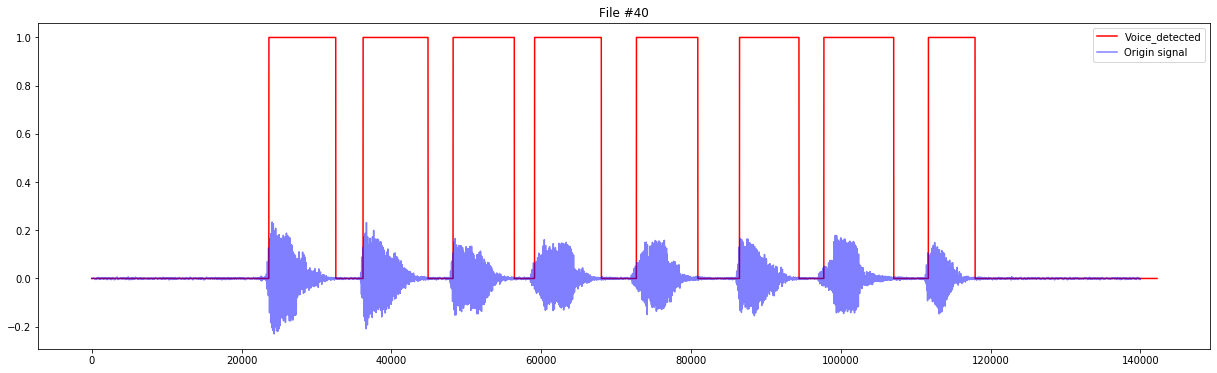

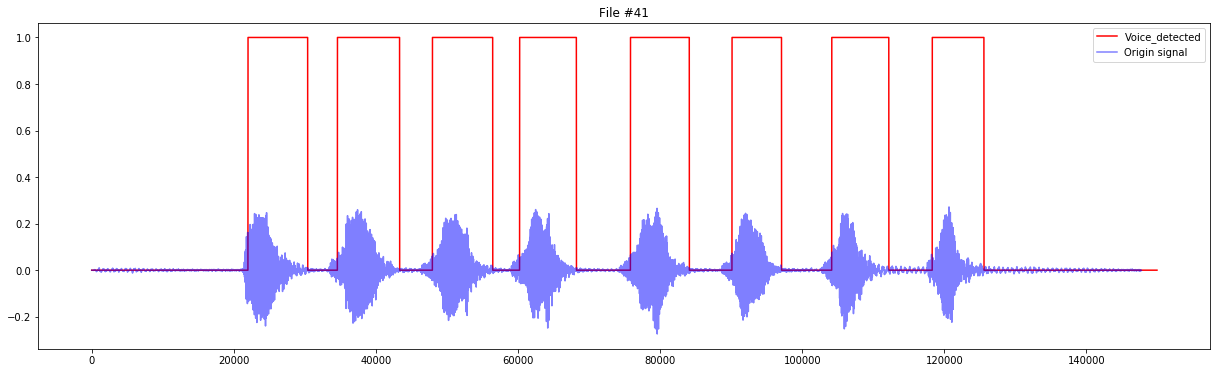

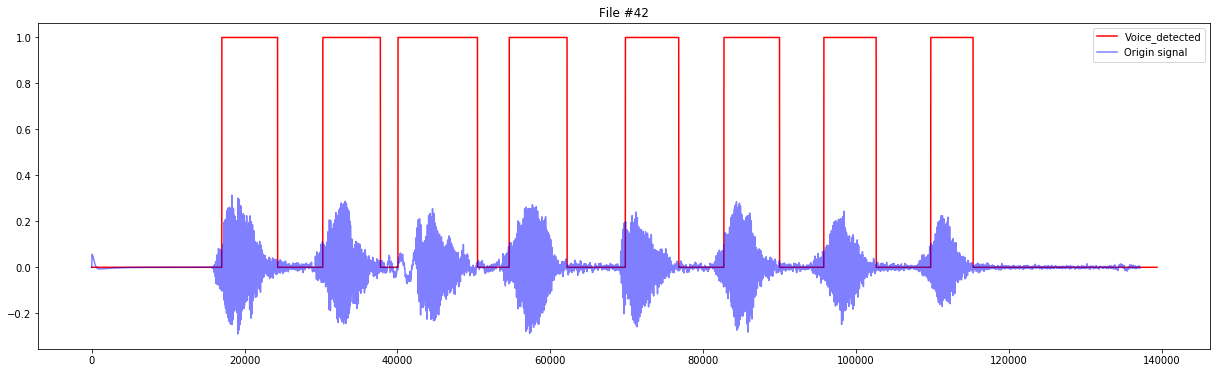

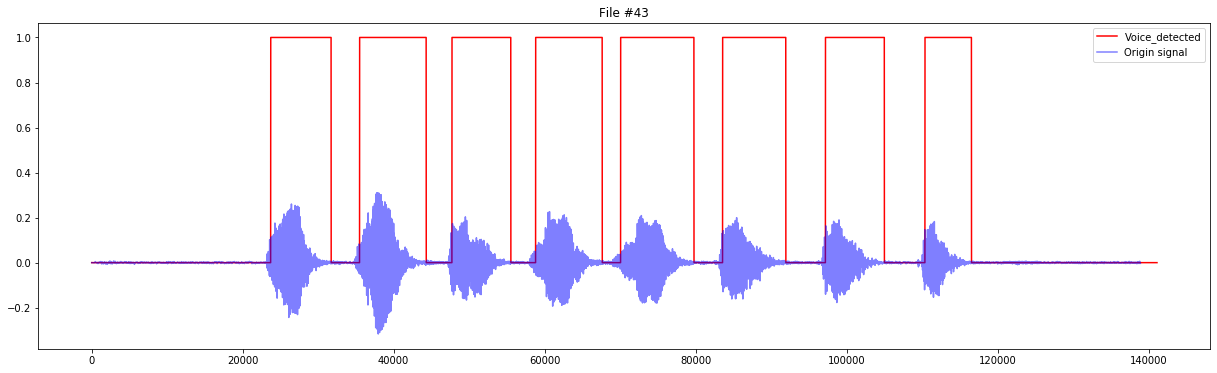

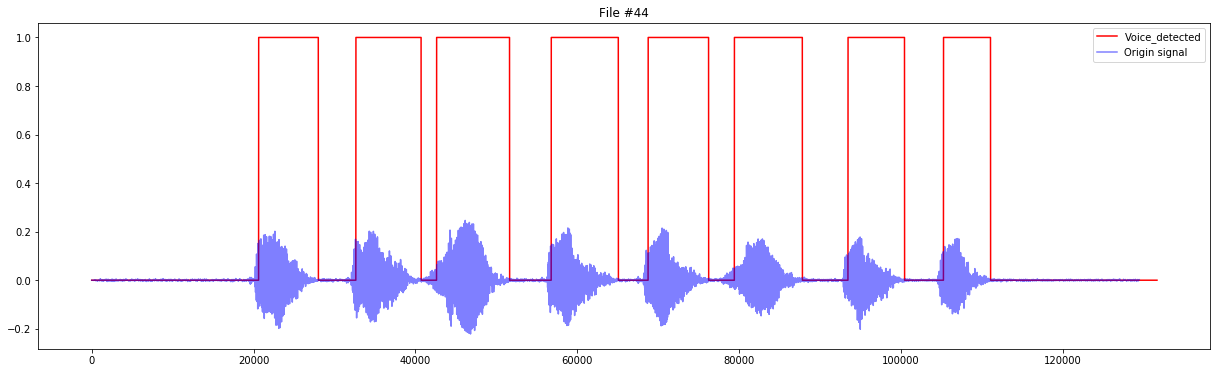

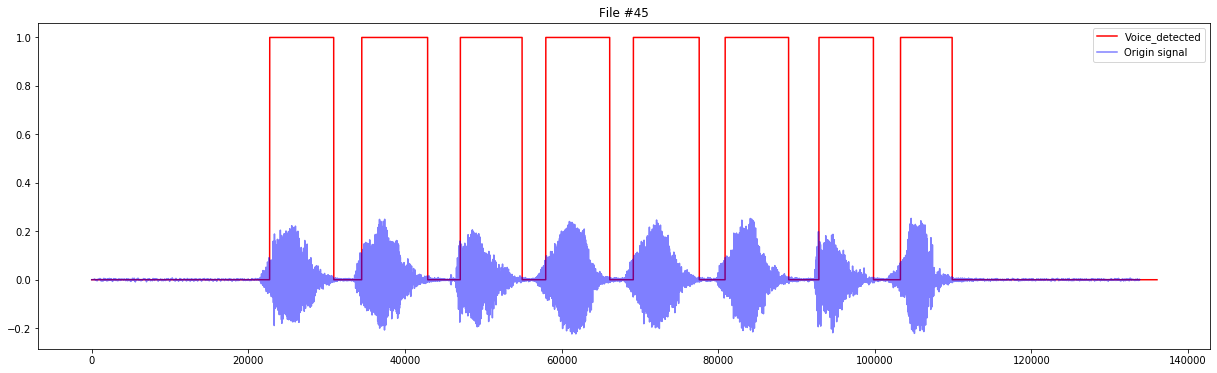

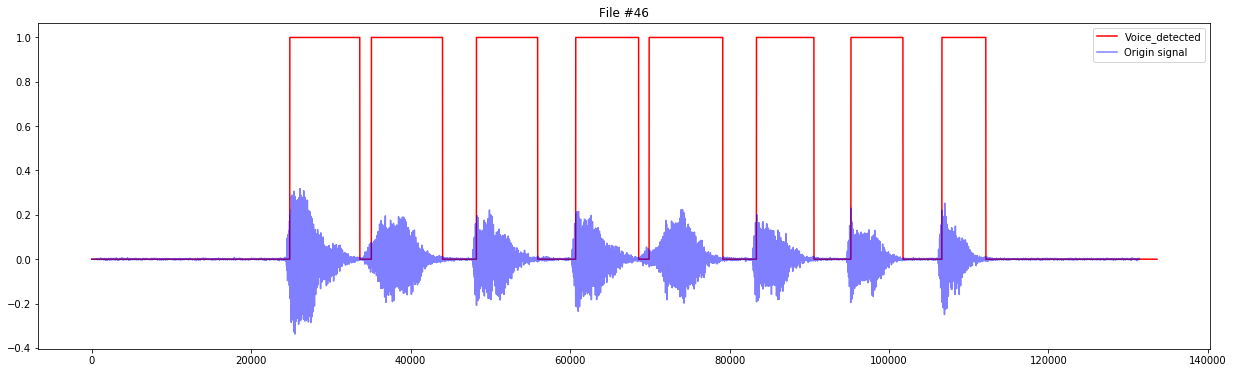

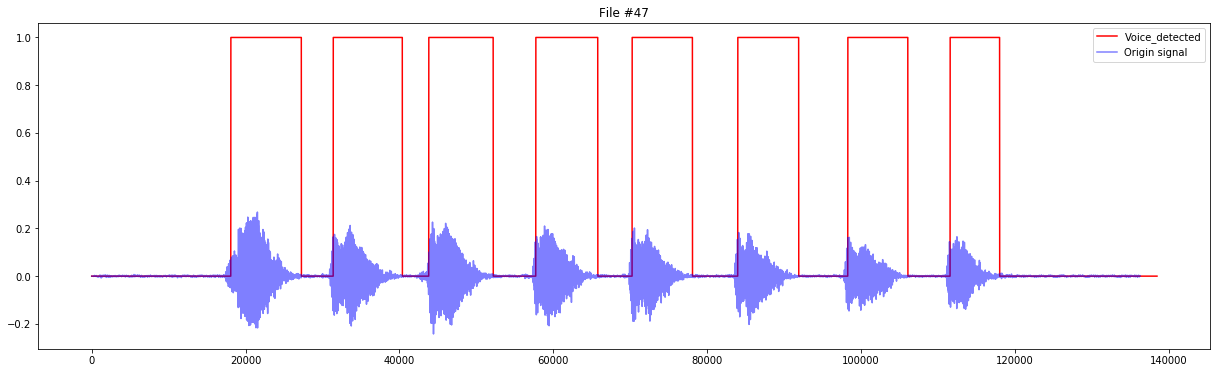

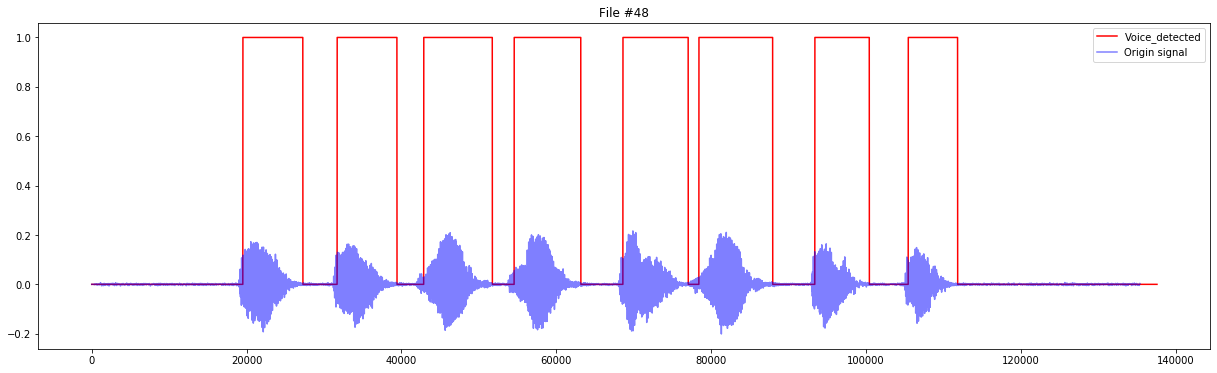

In [28]:
for index, X in enumerate(X_train):
    test = VAD(X, sr)
    test.find_voice(400)
    test.plot_voice(f'File #{index + 1}')

In [29]:
train_VA = [VAD(X, sr).find_voice(400) for x in X_train]
test_VA  = [VAD(X, sr).find_voice(400) for x in X_test]

In [30]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            print("Wrong number of words. Each audio contains 8 words")
            return -2
        return 0
    
    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:]  - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i} example"

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

# Задание *5 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки слов выделеных слов. Или любым другим удобным для вас способом. 

In [31]:
def make_dataset(X_train, Y_train, train_VA):
    X, y = [], []
    for idx in range(len(X_train)):
        start = np.where(np.diff(train_VA[idx]) == 1)[0]
        stop = np.where(np.diff(train_VA[idx]) == -1)[0]
        for i in range(8):
            mfcc = get_mfcc(X_train[idx][start[i]:stop[i]], sr = sr, n_mfcc=15).mean(axis = 1)
            X.append(mfcc)
            y.append(Y_train[idx][i])
    return np.array(X), np.array(y)

In [32]:
train_X, train_y = make_dataset(X_train, Y_train, train_VA)
test_X, test_y   = make_dataset(X_test,  Y_test,  test_VA)

In [33]:
from sklearn.svm import NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'gamma': ['scale', 'auto']}
cv = 5

classifier = NuSVC(random_state = 0)
grid_cv = GridSearchCV(classifier, param_grid, cv = cv)

grid_cv.fit(train_X, train_y);

In [34]:
print('Accuracy train: ', grid_cv.score(train_X, train_y))

Accuracy train:  0.9401041666666666


In [35]:
print('Accuracy test: ', grid_cv.score(test_X, test_y))

Accuracy test:  0.9479166666666666
